 # House Prices: Advance Regression Techniques(Kaggle)
 
 ## ID- AI-0019
## Submission date-10.11.2018

# Introduction


"House Prices: Advanced Regression Techniques"
This Project represents House Price prediction using ANN With 79 explanatory variables describing (almost) every aspect of 
residential homes in Ames, Iowa, this project challenges is  to predict the final price of each home. To predict the house price, the approach was several segments such as Data Analysis, Data Preprocessing, create Model, Hyperparatmeter tuning etc. The model was created by careful analysis of data visualization like data correlation, feature engineering, skewness reduction and other preprocessing to shape the model for the prediction. Final best score comes from Hyperparameter tuning.


# 1.Data Set Analysis

### 1.1 IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.neural_network import MLPRegressor
 
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split ,cross_val_score,GridSearchCV

from sklearn.preprocessing import normalize


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from pandas.plotting import scatter_matrix

%matplotlib inline

import sys

In [2]:
#load the csv file(Both train & test)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

Id=test['Id']
y_train = train.SalePrice.values

(1460, 81)
(1459, 80)


In [3]:
ntrain = train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [4]:
len(all_data)

2919

### 1.2 Missing Ratio check

In [5]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

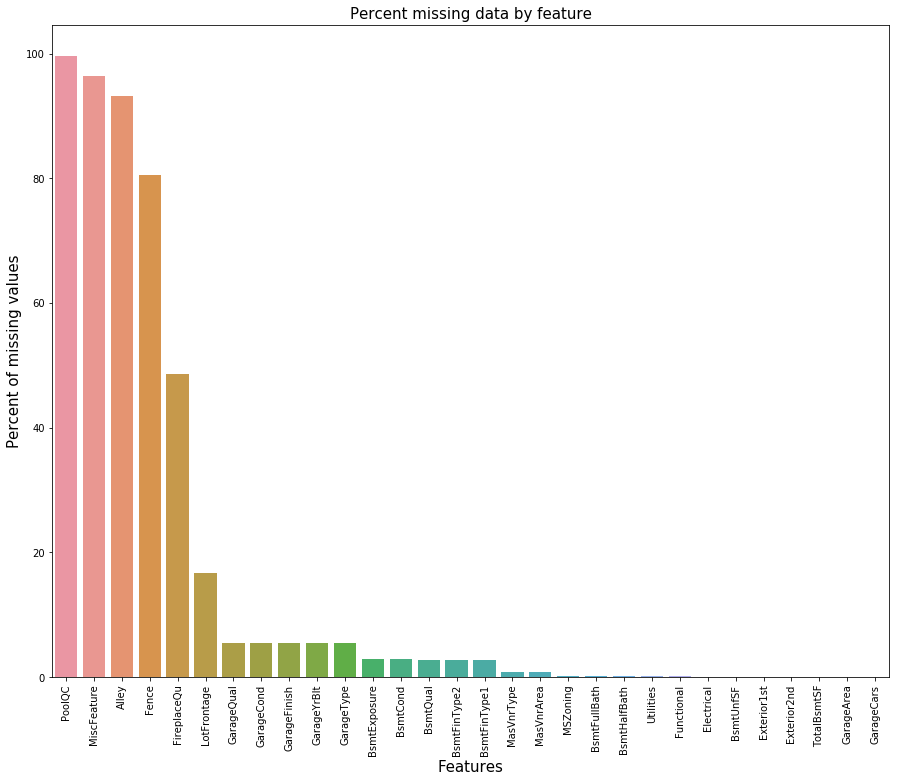

In [6]:
# visualization of missing data 
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


1. To see the all parameter and their value 
2. It helps to visualize the data type and missing value
3. In the next step data will preprocess and fill by making a function.

### 1.3 Data correlation

In [7]:
#importing the training dataset
data = pd.read_csv("train.csv")

print("Find most important features relative to target")
corr = data.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   

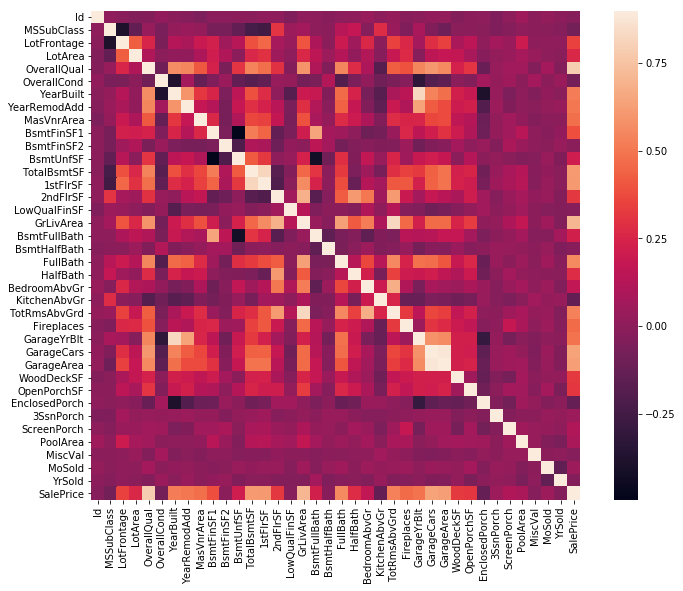

In [8]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

1. Heatmap and the most Correlated Features with the Target variable were represented with the Correlation
   Matrix.
2. Some Features that have a high Correlation(>0.8):
4. These are some important observations which can be exploited later on.


# 2. Data Processing 

### 2.1 Filling Missing Value

In [9]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

all_data = all_data.drop(['Utilities'], axis=1)

all_data.isnull().values.any()

False

1. Now, I preprocess the data using fillna function by none,mean,median, 0 and mode. 
2. At last, I have checked that there is not any missing value.

### 2.2 Data conversion

In [10]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


1. I convert file types into string to avoid future type error.
3. By using a for loop apply LabelEncoder to the categorical data.
4. After  that, check the shape of all_data.

In [11]:
all_data = pd.get_dummies(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]

In [12]:
test.isnull().values.any()
all_data.isnull().values.any()

False

### 2.3 Deleting outliers

In [13]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

outliers_dataframe = y_noano[y_noano['Top'] == -1]

print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 146
Number of rows without outliers: 1314


In [14]:
outliers_index = []
for index, row in outliers_dataframe.iterrows():
    outliers_index.append(index)
y_train = np.delete(y_train, outliers_index)


1. Documentation for the Ames Housing Data indicates that there are Outliers present in the Training Data.
2. delete some outliers.

### 2.4 Log Transform & Normal Distribution

c:\users\shihab\anaconda3\envs\tfp3.6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


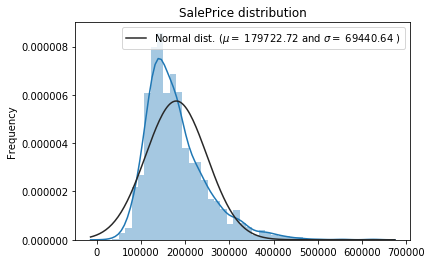

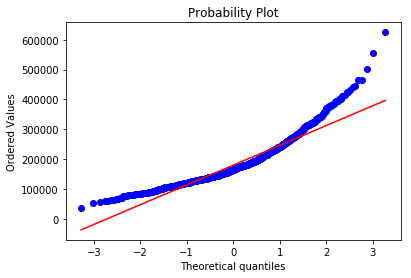

In [15]:
sns.distplot(y_train , fit=stats.norm);

(mu, sigma) = stats.norm.fit(y_train)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

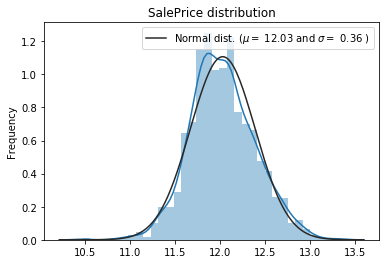

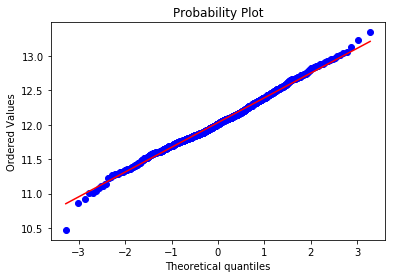

In [16]:
y_train = np.log1p(y_train)
sns.distplot(y_train , fit=stats.norm);

(mu, sigma) = stats.norm.fit(y_train)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

### 2.5 skewness

In [17]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
#Skewness is a term in statistics used to describes asymmetry from the normal distribution
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features for train: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features for train: 



,Skew
Exterior2nd_CBlock,36.207744
Exterior1st_AsphShn,36.207744
Exterior1st_CBlock,36.207744
MiscFeature_TenC,36.207744
Exterior1st_ImStucc,36.207744
Electrical_Mix,36.207744
SaleType_Con,36.207744
Exterior2nd_Other,36.207744
MiscFeature_Gar2,36.207744
Heating_Wall,36.207744


In [18]:
numeric_feats = test.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
#Skewness is a term in statistics used to describes asymmetry from the normal distribution
skewed_feats = test[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features for test: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features for test: 



,Skew
Exterior1st_AsphShn,38.157577
RoofMatl_WdShngl,38.157577
Exterior1st_CBlock,38.157577
Exterior2nd_AsphShn,38.157577
Exterior2nd_Stone,38.157577
Heating_Wall,26.953689
Exterior2nd_CBlock,26.953689
Condition2_PosN,26.953689
Heating_Grav,26.953689
MiscFeature_Othr,26.953689


In [19]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

There are 221 skewed numerical features to Box Cox transform


In [20]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    test[feat] = boxcox1p(test[feat], lam)

There are 221 skewed numerical features to Box Cox transform


1. Most of the algorithms by default assume that the target follows a normal distribution. If that is not the case, then, the accuracy falls. 
2. In this section, we will take a look at the 'SalePrice' from a probabilistic viewpoint and transform it if necessary.

3. Log Transformation was applied to the Target Variable because of its high skewness.
4. My target feature 'saleprice''s probability graph is in a straight line which will give me the good accuracy.

In [21]:
train.shape

(1314, 221)

# 3. Different Model Apply

## 3.1 Scikit learn

In [22]:
import sklearn.neural_network as sknn
import sklearn.model_selection as mods
import warnings
warnings.filterwarnings('ignore')

rgr = sknn.MLPRegressor(hidden_layer_sizes=(300,200,100), activation='identity',solver='adam', alpha=1)
CVS = mods.cross_val_score(rgr, train, y_train, cv=5) # Cross Validation Scores
rgr = rgr.fit(train, y_train)
Pred_sklrn = rgr.predict(test)
print('\nAverage Accuracy(R2) Score(5 Fold Cross Validation):', sum(CVS)/5)

# Inverse log1p Transformation
Pred_sk_log1 = np.expm1(Pred_sklrn).flatten()
Pred_data = pd.DataFrame({'Id':Id, 'SalePrice':Pred_sk_log1})
Pred_data['SalePrice'] = Pred_data['SalePrice'].transform(lambda x: (x-1))

# CSV File(Kaggle Format)
Pred_data.to_csv('Vanilla.csv', index=False)


Average Accuracy(R2) Score(5 Fold Cross Validation): 0.9033034730779083


1. Basic ANN model was used by scikit learn.
2. 5 fold cross validation was used.
3. kaggle score = 0.12968

## 3.2 keras

In [23]:
# Learner(Vanilla/Basic Model)
from keras.models import Sequential
from keras.layers import Dense
model1 = Sequential()

# Stack of Layers
model1.add(Dense(units=300, activation='relu', input_dim=221))
model1.add(Dense(units=200, activation='relu'))
model1.add(Dense(units=100, activation='relu'))
model1.add(Dense(units=1, activation='relu'))
model1.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

#Average Accuracy(R2) Score(5 Fold Cross Validation): 0.0.895066447445
# Training of Model(Train Data is splitted into 80/20)

print(type(train))
print(type(y_train))

Xtrn, Xvalid, Ytrn, Yvalid = train_test_split(train, y_train,test_size=0.2)
kMod = model1.fit(Xtrn, Ytrn, validation_split=0.2, epochs=1000, batch_size=54,verbose=0)
Error = model1.evaluate(Xvalid, Yvalid, batch_size=54, verbose=0)
print('\nLoss(Based on Validation Set):', Error)

# Training of Model(All the Train Data are fitted to the Model)
model1.fit(train, y_train, validation_split=0.2, epochs=1000,
batch_size=54, verbose=0)
Pred_keras = model1.predict(test, batch_size=54) # log1p Transformed Predictions

# Inverse log1p Transformation
Pred_kr = np.expm1(Pred_keras).flatten()
Pred_kr = pd.DataFrame({'Id':Id, 'SalePrice':Pred_kr})
Pred_kr['SalePrice'] = Pred_kr['SalePrice'].transform(lambda x: (x-1))
# CSV File(Kaggle Format)
Pred_kr.to_csv('keras(Vanilla).csv', index=False)

Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>

Loss(Based on Validation Set): 0.00014559936852675965


1. keras was used with tensorflow backend for deep model.
2. Hidden layer was used 300, 200, 100 for better accuracy.There is no hard rule.
3. split the data to check overfitting. Then, fit all train data.
4. kaggle score is 0.15929

## 3.3 Regularization

In [24]:
from keras import regularizers
model2 = Sequential()
# Stack of Layers

model2.add(Dense(units=300, activation='relu',
kernel_regularizer=regularizers.l2(.25), input_dim=221)) # Regularization
model2.add(Dense(units=200, activation='relu'))
model2.add(Dense(units=100, activation='relu'))
model2.add(Dense(units=1, activation='relu'))
model2.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

# Training of Model(All the Train Data are fitted to the Model)
model2.fit(train, y_train, validation_split=0.2, epochs=1000,
batch_size=54, verbose=0)
Pred_keras = model2.predict(test, batch_size=54) # log1p TransformedPredictions

# Inverse log1p Transformation
Pred_kr = np.expm1(Pred_keras).flatten()
Pred_kr = pd.DataFrame({'Id':Id, 'SalePrice':Pred_kr})
Pred_kr['SalePrice'] = Pred_kr['SalePrice'].transform(lambda x: (x-1))

# CSV File(Kaggle Format)
Pred_kr.to_csv('keras_Rgl.csv', index=False)

1. kaggle score did not improve by use regulization techniques.
2. In later model, regulization was not used.
3. kaggle score= 0.23641

## 3.4 Droupout

In [25]:
from keras.layers import Dropout
from keras.constraints import maxnorm
model3 = Sequential()

# Stack of Layers
model3.add(Dense(units=300, activation='relu', kernel_constraint=maxnorm(3),input_dim=221))
model3.add(Dropout(0.01))
model3.add(Dense(units=200, activation='relu'))
model3.add(Dropout(0.01))
model3.add(Dense(units=100, activation='relu'))
model3.add(Dense(units=1, activation='relu'))
model3.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

# Training of Model(All the Train Data are fitted to the Model)
model3.fit(train, y_train, validation_split=0.2, epochs=1000,batch_size=54, verbose=0)
Pred_keras = model3.predict(test, batch_size=54) # log1p TransformedPredictions

# Inverse log1p Transformation
Pred_kr = np.expm1(Pred_keras).flatten()
Pred_kr = pd.DataFrame({'Id':Id, 'SalePrice':Pred_kr})
Pred_kr['SalePrice'] = Pred_kr['SalePrice'].transform(lambda x: (x-1))

# CSV File(Kaggle Format)
Pred_kr.to_csv('keras_drop.csv', index=False)

1. kaggle score did not improve by used dropout may be due to overfitting.
2. kaggle score is =0.24712

## 3.5 Batch Normalization

In [26]:
from keras.layers import BatchNormalization
model4 = Sequential()

# Stack of Layers
model4.add(Dense(units=300, activation='relu', input_dim=221))
model4.add(BatchNormalization())
model4.add(Dense(units=200, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(units=100, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(units=1, activation='relu'))
model4.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

# Training of Model(All the Train Data are fitted to the Model)
model4.fit(train, y_train, validation_split=0.2, epochs=1000,batch_size=54, verbose=0)
Pred_keras = model4.predict(test, batch_size=54) # log1p TransformedPredictions

# Inverse log1p Transformation
Pred_kr = np.expm1(Pred_keras).flatten()
Pred_kr = pd.DataFrame({'Id':Id, 'SalePrice':Pred_kr})
Pred_kr['SalePrice'] = Pred_kr['SalePrice'].transform(lambda x: (x-1))

# CSV File(Kaggle Format)
Pred_kr.to_csv('keras_batch.csv', index=False)

1. its also frustarting kaggle score may be due to overfitting.
2. kaggle score= 0.45943

## 3.6 Hyper parameter Tuning of ANN

In [27]:
train.shape

(1314, 221)

In [28]:
feature_size=train.shape[1]
last_layer =1

FH = (feature_size+last_layer)//2
SH = (FH+last_layer)//2
TH = (SH+last_layer)//2
FoH = (TH+last_layer)//2
FiH = (FoH+last_layer)//2
print(FH, SH, TH, FoH, FiH)

111 56 28 14 7



#### Determining the number of node in a hidden layer: Thumb Rule

A Thumb Rule recommended by Geoff Hinton was applied for choosing the best number of Hidden Layers. Number of Neurons on each Layer was tuned according to the Thumb Rule that says, 'Number of
Neurons on each Layer should be somewhere between the size of the input and output layer, potentially the mean'.

There is no hard and fast rule.we have some rule of thumb for approximation.

In [29]:
Reg = MLPRegressor(hidden_layer_sizes=(FH,SH,TH),max_iter=1000,verbose=False)
activation_options = ['identity','tanh','logistic','relu']
solver_options = ['lbfgs','adam']
alpha_options = [0.0001]
tol_options = [0.0001]
learning_rate_options = ['constant','adaptive']
param_grid_MLPReg = dict(activation = activation_options,
                       solver = solver_options,
                       alpha = alpha_options,
                       learning_rate = learning_rate_options,
                        tol=tol_options)
gridMLPReg = GridSearchCV(Reg,param_grid=param_grid_MLPReg,cv=10,scoring ='r2',verbose=2)

In [30]:
gridMLPReg.fit(train,y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.8s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.7s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.4s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.7s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.7s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  14.7s
[CV] activation=identity, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=identity

[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  26.9s
[CV] activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  26.8s
[CV] activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  27.0s
[CV] activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  26.8s
[CV] activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  26.7s
[CV] activation=tanh, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=tanh, alpha=0.0001, learning_rate=constant, solv

[CV]  activation=logistic, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  20.5s
[CV] activation=logistic, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001 
[CV]  activation=logistic, alpha=0.0001, learning_rate=constant, solver=lbfgs, tol=0.0001, total=  20.5s
[CV] activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=  10.5s
[CV] activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   6.6s
[CV] activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   6.5s
[CV] activation=logistic, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=logistic, alpha

[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   5.6s
[CV] activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   4.0s
[CV] activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   3.0s
[CV] activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   3.9s
[CV] activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001, total=   4.9s
[CV] activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, tol=0.0001 
[CV]  activation=relu, alpha=0.0001, learning_rate=constant, solver=adam, t

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 33.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(111, 56, 28), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['identity', 'tanh', 'logistic', 'relu'], 'solver': ['lbfgs', 'adam'], 'alpha': [0.0001], 'learning_rate': ['constant', 'adaptive'], 'tol': [0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [31]:
gridMLPReg.best_params_

{'activation': 'identity',
 'alpha': 0.0001,
 'learning_rate': 'constant',
 'solver': 'lbfgs',
 'tol': 0.0001}

In [32]:
gridMLPReg.best_score_

0.9151446796974404

1. Grid Search was run and best Optimizer was found.
2. First the Train Data was fitted to the Model and get the best score.
3. find out the best combination of the model.

In [33]:

Pred_grid = np.expm1(gridMLPReg.predict(test)).flatten()
Pred_grid = pd.DataFrame({'Id':Id, 'SalePrice':Pred_grid})
Pred_grid['SalePrice'] = Pred_grid['SalePrice'].transform(lambda x: (x-1))

Pred_grid.to_csv('grid_search.csv',index=0)

### kaggle score=0.12458

# 4. Tensorflow Approach

In [34]:
import tensorflow as tf

Tensorflow require array as input. conerted dataframe to array.

In [35]:
x_train = train.values
x_train

array([[11.69262259, 11.68618938,  0.        , ...,  0.        ,
         0.        ,  0.73046315],
       [12.79227623,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.73046315],
       [11.89203906, 11.72459848,  0.        , ...,  0.        ,
         0.        ,  0.73046315],
       ...,
       [12.6168403 , 12.52811325,  0.        , ...,  0.        ,
         0.        ,  0.73046315],
       [12.33807443,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.73046315],
       [12.77838192,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.73046315]])

In [36]:
y_train=np.reshape(np.array(y_train),(1314,1))

print(y_train.shape)

(1314, 1)


check the dimension of the input and outout

In [37]:
input_dim = x_train.shape[1]
print(input_dim)
output_dim = 1

221


I declare the node of the layer. There is no hard and fast rule to the number of nodes. But I worked before according this number. # 221 111 56 28 14 7 

In [38]:
Hl_1 = 221
Hl_2 = 111
Hl_3 = 56
Hl_4 = 28
Hl_5 = 14
Hl_6 = 7

Tensorflow takes value through placeholder. Placeholder is empty nodes. we will get tensor through placeholder. I have create two placeholder and check their type for avoiding future error.

In [39]:
X = tf.placeholder("float", [None, input_dim])
Y = tf.placeholder("float", [None, output_dim])

print(type(X))
print(type(Y))

#X_float32= tf.placeholder(tf.float32, [None, input_dim])
#Y_float32 = tf.placeholder(tf.float32, [None, output_dim])

#print(type(X_float32))





<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


I have initialize weight and biases with xavier_initializer according to the instruction of all expert in machine learning

In [40]:
weights = {
    'w1': tf.Variable(tf.contrib.layers.xavier_initializer()((input_dim, Hl_1))),
    'w2': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_1, Hl_2))),
    'w3': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_2, Hl_3))),
    'w4': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_3, Hl_4))),
    'w5': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_4, Hl_5))),
    'w6': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_5, Hl_6))),
    'out': tf.Variable(tf.contrib.layers.xavier_initializer()((Hl_6, output_dim)))
   
   
}
biases = {
    'b1': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_1])),
    'b2': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_2])),
    'b3': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_3])),
    'b4': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_4])),
    'b5': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_5])),
    'b6': tf.Variable(tf.contrib.layers.xavier_initializer()([Hl_6])),
    'out': tf.Variable(tf.contrib.layers.xavier_initializer()([output_dim]))
}

print("ok")

ok


In [41]:

#making hidden layer with activation function

def neural_net(x):
    
    # hidden layer 1
    Z1 = tf.add(tf.matmul(x, weights['w1']),biases['b1'])                                            
    A1 = tf.nn.relu(Z1) 
    
    # hidden layer 2
    Z2 = tf.add(tf.matmul(A1, weights['w2']),biases['b2'])                                              
    A2 = tf.nn.relu(Z2)    
    
    # hidden layer 3
    Z3 = tf.add(tf.matmul(A2, weights['w3']),biases['b3'])                                              
    A3 = tf.nn.relu(Z3)   
    
    # hidden layer 4
    Z4 = tf.add(tf.matmul(A3, weights['w4']),biases['b4'])                                              
    A4 = tf.nn.relu(Z4) 
    
    # hidden layer 5
    Z5 = tf.add(tf.matmul(A4, weights['w5']),biases['b5'])                                              
    A5 = tf.nn.relu(Z5)
    
    # hidden layer 6
    Z6 = tf.add(tf.matmul(A5, weights['w6']),biases['b6'])
    A6 = tf.nn.tanh(Z6)
    
    #output layer
    out_layer = tf.matmul(A6, weights['out']) + biases['out']
    return (out_layer)



In [42]:
Y1=neural_net(X)



loss=tf.losses.mean_squared_error(Y,Y1)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
epoch=2000
with tf.Session() as sess:
    sess.run(init)
    for i in range(0,epoch):
        sess.run(train,feed_dict={X:x_train,Y:y_train})
        losss=sess.run(loss,feed_dict={X:x_train,Y:y_train})
        
        print("epoch no"+str(i),(losss))
    pred=sess.run(Y1,feed_dict={X:test})
    print(len(pred))
    


epoch no0 89.603226
epoch no1 63.011444
epoch no2 45.93235
epoch no3 45.29573
epoch no4 44.582253
epoch no5 43.813763
epoch no6 43.003685
epoch no7 42.165676
epoch no8 41.30921
epoch no9 40.44105
epoch no10 39.566227
epoch no11 38.688534
epoch no12 37.810993
epoch no13 36.93597
epoch no14 36.065388
epoch no15 35.20084
epoch no16 34.343605
epoch no17 33.4948
epoch no18 32.655323
epoch no19 31.825947
epoch no20 31.007317
epoch no21 30.200012
epoch no22 29.404478
epoch no23 28.621105
epoch no24 27.850239
epoch no25 27.092138
epoch no26 26.347054
epoch no27 25.615139
epoch no28 24.896568
epoch no29 24.191427
epoch no30 23.499828
epoch no31 22.821785
epoch no32 22.157358
epoch no33 21.506527
epoch no34 20.869305
epoch no35 20.245632
epoch no36 19.63547
epoch no37 19.038767
epoch no38 18.45542
epoch no39 17.88535
epoch no40 17.328459
epoch no41 16.784616
epoch no42 16.253712
epoch no43 15.7355995
epoch no44 15.230147
epoch no45 14.737219
epoch no46 14.256652
epoch no47 13.788285
epoch no48 1

epoch no373 0.12991866
epoch no374 0.12991866
epoch no375 0.12991866
epoch no376 0.12991866
epoch no377 0.12991866
epoch no378 0.12991866
epoch no379 0.12991866
epoch no380 0.12991866
epoch no381 0.12991866
epoch no382 0.12991866
epoch no383 0.12991866
epoch no384 0.12991866
epoch no385 0.12991866
epoch no386 0.12991866
epoch no387 0.12991866
epoch no388 0.12991866
epoch no389 0.12991866
epoch no390 0.12991866
epoch no391 0.12991866
epoch no392 0.12991866
epoch no393 0.12991866
epoch no394 0.12991866
epoch no395 0.12991866
epoch no396 0.12991866
epoch no397 0.12991866
epoch no398 0.12991866
epoch no399 0.12991866
epoch no400 0.12991866
epoch no401 0.12991866
epoch no402 0.12991866
epoch no403 0.12991866
epoch no404 0.12991866
epoch no405 0.12991866
epoch no406 0.12991866
epoch no407 0.12991866
epoch no408 0.12991866
epoch no409 0.12991866
epoch no410 0.12991866
epoch no411 0.12991866
epoch no412 0.12991866
epoch no413 0.12991866
epoch no414 0.12991866
epoch no415 0.12991866
epoch no416

epoch no733 0.12991866
epoch no734 0.12991866
epoch no735 0.12991866
epoch no736 0.12991866
epoch no737 0.12991866
epoch no738 0.12991866
epoch no739 0.12991866
epoch no740 0.12991866
epoch no741 0.12991866
epoch no742 0.12991866
epoch no743 0.12991866
epoch no744 0.12991866
epoch no745 0.12991866
epoch no746 0.12991866
epoch no747 0.12991866
epoch no748 0.12991866
epoch no749 0.12991866
epoch no750 0.12991866
epoch no751 0.12991866
epoch no752 0.12991866
epoch no753 0.12991866
epoch no754 0.12991866
epoch no755 0.12991866
epoch no756 0.12991866
epoch no757 0.12991866
epoch no758 0.12991866
epoch no759 0.12991866
epoch no760 0.12991866
epoch no761 0.12991866
epoch no762 0.12991866
epoch no763 0.12991866
epoch no764 0.12991866
epoch no765 0.12991866
epoch no766 0.12991866
epoch no767 0.12991866
epoch no768 0.12991866
epoch no769 0.12991866
epoch no770 0.12991866
epoch no771 0.12991866
epoch no772 0.12991866
epoch no773 0.12991866
epoch no774 0.12991866
epoch no775 0.12991866
epoch no776

epoch no1090 0.12991866
epoch no1091 0.12991866
epoch no1092 0.12991866
epoch no1093 0.12991866
epoch no1094 0.12991866
epoch no1095 0.12991866
epoch no1096 0.12991866
epoch no1097 0.12991866
epoch no1098 0.12991866
epoch no1099 0.12991866
epoch no1100 0.12991866
epoch no1101 0.12991866
epoch no1102 0.12991866
epoch no1103 0.12991866
epoch no1104 0.12991866
epoch no1105 0.12991866
epoch no1106 0.12991866
epoch no1107 0.12991866
epoch no1108 0.12991866
epoch no1109 0.12991866
epoch no1110 0.12991866
epoch no1111 0.12991866
epoch no1112 0.12991866
epoch no1113 0.12991866
epoch no1114 0.12991866
epoch no1115 0.12991866
epoch no1116 0.12991866
epoch no1117 0.12991866
epoch no1118 0.12991866
epoch no1119 0.12991866
epoch no1120 0.12991866
epoch no1121 0.12991866
epoch no1122 0.12991866
epoch no1123 0.12991866
epoch no1124 0.12991866
epoch no1125 0.12991866
epoch no1126 0.12991866
epoch no1127 0.12991866
epoch no1128 0.12991866
epoch no1129 0.12991866
epoch no1130 0.12991866
epoch no1131 0.1

epoch no1435 0.12991866
epoch no1436 0.12991866
epoch no1437 0.12991866
epoch no1438 0.12991866
epoch no1439 0.12991866
epoch no1440 0.12991866
epoch no1441 0.12991866
epoch no1442 0.12991866
epoch no1443 0.12991866
epoch no1444 0.12991866
epoch no1445 0.12991866
epoch no1446 0.12991866
epoch no1447 0.12991866
epoch no1448 0.12991866
epoch no1449 0.12991866
epoch no1450 0.12991866
epoch no1451 0.12991866
epoch no1452 0.12991866
epoch no1453 0.12991866
epoch no1454 0.12991866
epoch no1455 0.12991866
epoch no1456 0.12991866
epoch no1457 0.12991866
epoch no1458 0.12991866
epoch no1459 0.12991866
epoch no1460 0.12991866
epoch no1461 0.12991866
epoch no1462 0.12991866
epoch no1463 0.12991866
epoch no1464 0.12991866
epoch no1465 0.12991866
epoch no1466 0.12991866
epoch no1467 0.12991866
epoch no1468 0.12991866
epoch no1469 0.12991866
epoch no1470 0.12991866
epoch no1471 0.12991866
epoch no1472 0.12991866
epoch no1473 0.12991866
epoch no1474 0.12991866
epoch no1475 0.12991866
epoch no1476 0.1

epoch no1779 0.12991866
epoch no1780 0.12991866
epoch no1781 0.12991866
epoch no1782 0.12991866
epoch no1783 0.12991866
epoch no1784 0.12991866
epoch no1785 0.12991866
epoch no1786 0.12991866
epoch no1787 0.12991866
epoch no1788 0.12991866
epoch no1789 0.12991866
epoch no1790 0.12991866
epoch no1791 0.12991866
epoch no1792 0.12991866
epoch no1793 0.12991866
epoch no1794 0.12991866
epoch no1795 0.12991866
epoch no1796 0.12991866
epoch no1797 0.12991866
epoch no1798 0.12991866
epoch no1799 0.12991866
epoch no1800 0.12991866
epoch no1801 0.12991866
epoch no1802 0.12991866
epoch no1803 0.12991866
epoch no1804 0.12991866
epoch no1805 0.12991866
epoch no1806 0.12991866
epoch no1807 0.12991866
epoch no1808 0.12991866
epoch no1809 0.12991866
epoch no1810 0.12991866
epoch no1811 0.12991866
epoch no1812 0.12991866
epoch no1813 0.12991866
epoch no1814 0.12991866
epoch no1815 0.12991866
epoch no1816 0.12991866
epoch no1817 0.12991866
epoch no1818 0.12991866
epoch no1819 0.12991866
epoch no1820 0.1

In [43]:
print(pred)

[[12.03277]
 [12.03277]
 [12.03277]
 ...
 [12.03277]
 [12.03277]
 [12.03277]]


In [44]:
# Inverse log1p Transformation
Pred_tf = np.expm1(pred).flatten()
Pred_tf = pd.DataFrame({'Id':Id, 'SalePrice':Pred_tf})
Pred_tf['SalePrice'] = Pred_tf['SalePrice'].transform(lambda x: (x-1))

# CSV File(Kaggle Format)
Pred_tf.to_csv('tensorflow.csv', index=False)

#### kaggle score = 0.14403

Dropout should only be introduced during training, not evaluation.TensorFlow provides nn.dropout() for that, but as this is regression problem & I have applied dropout and regularization in keras model(backend is tensorflow) which can not improve my score.So I have not applied dropout and regularization.

### 4.1 Shallow Neural Network

After applying all the approach, score is not better than around 0.12458. So I took a different approach toward the problem. That is- shallow network.The main portion of this code is written in tensorflow. So, we need to transform some data to special format. And for that need, the data is processsed in a different but simpler way. Sometimes one hidden layer with large number of neurons can solve complex regression problems. 

In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import itertools

#Reading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Drop the ID
train.drop('Id',axis = 1, inplace = True)
ID = test.Id
test.drop('Id',axis = 1, inplace = True)

#isolate categorical and numeric features
train_numerical = train.select_dtypes(exclude=['object'])
train_categoric = train.select_dtypes(include=['object'])
test_numerical = test.select_dtypes(exclude=['object'])
test_categoric = test.select_dtypes(include=['object'])

#impute missing values
train_numerical.fillna(0,inplace = True)
train_categoric.fillna('NONE',inplace = True)
test_numerical.fillna(0,inplace = True)
test_categoric.fillna('NONE',inplace = True)

#Merge all features
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

#Outlier dropping
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values
train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)
train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)
train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

#Get the column names
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)
col_train_cat = list(train_categoric.columns)

#remove the Target
col_train_num_bis.remove('SalePrice')

#Convert to numpy array (For scaling)
mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice)

#Scaling the dataset
prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(1314,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

#Make new dataframe
train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

#Feature engineering / data transformation for tensorflow
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"
FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(
        sparse_id_column=sparse_column, dimension=16,combiner="sum"))

training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.SalePrice


In [46]:
# Number of nodes
node_nb = 1200

#Validation Set ratio
TTR = .2

#Epoch
EPCH = 3000



#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=TTR, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)


training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]


y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test,
                                                                            left_index = True, right_index = True)

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[node_nb])


#Treat numeric and categorical data differently with this function
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], 
        values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        label = tf.constant(data_set[LABEL].values)

        
        return feature_cols, label
    
    return feature_cols

#Fit the data to the model
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps= EPCH)

#Evaluate
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score5))

#Predict
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    

#CSV generator function
def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), 
                             columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)

    
#Export result to csv
to_submit(y_predict, " Shallow_submission")

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000242C2A8C668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\shihab\AppData\Local\Temp\tmp0dc4eowl\model.ckpt.
INFO:tensorflow:loss = 0.13545285, step = 1
INFO:tensorflow:global_step/sec: 7.59266
INFO:tensorflow:loss = 0.002843718, step = 101 (13.173 sec)
INFO:tensorflow:global_step/sec: 9.44435
INFO:tensorflow:loss = 0.0023174866, step = 201 (10.592 sec)
INFO:tensorflow:global_step/sec: 9.35431
INFO:tensorflow:loss = 0.002036394, step = 301 (10.685 sec)
INFO:tensorflow:global_step/sec: 9.46056
INFO:tensorflow:loss = 0.0018580979, step = 401 (10.569 sec)
INFO:tensorflow:global_step/sec: 9.37143
INFO:tensorflow:loss = 0.0017295404, step = 501 (10.679 sec)
INFO:tens

INFO:tensorflow:Starting evaluation at 2018-11-10-09:41:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\shihab\AppData\Local\Temp\tmp0dc4eowl\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-11-10-09:41:56
INFO:tensorflow:Saving dict for global step 3000: global_step = 3000, loss = 0.0015123453
Final Loss on the testing set: 0.001512
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\shihab\AppData\Local\Temp\tmp0dc4eowl\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### 4.1 Result Grid

1. node_nb =1200        ,       TTR= .2        ,       EPCH= 3000         ,         Score= 0.11693

2. node_nb =1800        ,       TTR= .3        ,        EPCH= 2000        ,         Score= 0.11913

3. node_nb =1000        ,       TTR= .2        ,        EPCH= 1500        ,         Score= 0.11903

# 5. Best score in Kaggle

### kaggle best score is 0.11693

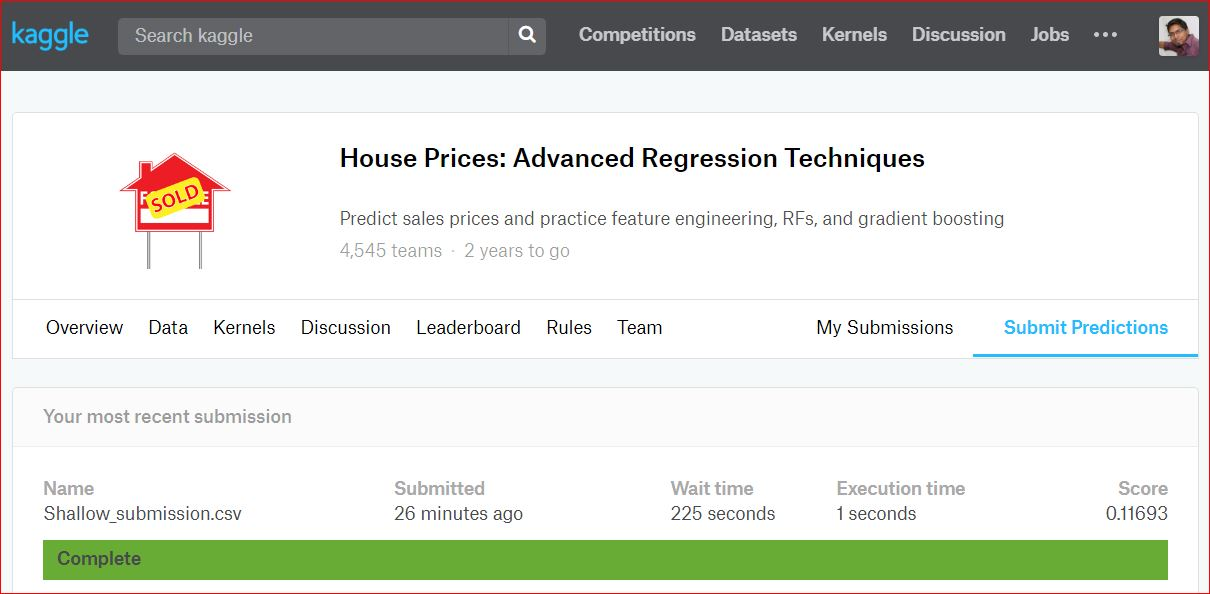

In [47]:
from IPython.display import Image
Image('improve_score.JPG')

# 6. Reference

1. . Outlier detection -  http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
2. . Data distribution & skewness -  http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-21.html
3. . Box-Cox transformation - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
4. . Number of noods for ANN - http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html
5. . Tuner(parameter tuning) - http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
6. . shallow neural network- https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow
7. . Tensorflow - https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/

# 7. conclusion


1. Feature Engineering, Outlier Removal, Skewness Reduction and Hyper Parameter Tuning had great impact
   on the improvement of the Score.  
2. Neural Network has an Inherent Tendency to overfit. Further improvement of the Score is deteriorated
   due to this contingency. 
3. Unfortunately, Deep model didn't provide the good kaggle score.On the otherhand, grid search was excellent kaggle score.
4. From the project we did, we can say that Shallow Neural Network provides the best result with a kaggle 
   score of 0.11693. However, with proper tuning of neural network size and nodes, the result may vary.     
5. Also different algorithms such as XGBoost might provide higher accuracy in a regressor problem.
